# Modeling void fraction in fluid channel using cross-sectional disks

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [17]:
import os
import cv2
import numpy as np
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import patches


from shapely.geometry import LineString, Point
from shapely.geometry.polygon import Polygon

from scipy.optimize import curve_fit

from scipy.interpolate import splrep
from scipy.interpolate import splev

# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, title='', size=None):
    """Creates a custom plot configuration to make graphs look nice.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

def get_channel(channel_shape):
    """Return list of all index coordinates of the empty channel."""
    # get list of ordered pairs of channel index coordinates
    yy_channel, xx_channel = np.indices(channel_shape)
    channel_coords = np.column_stack(
        (np.ravel(xx_channel), np.ravel(yy_channel)))
    return channel_coords

def get_bubbles(model_info, channel):
    """Get random bubble radii and center coordinates."""
    # get number of bubbles and radii limits
    num = model_info['num_of_bubbles_to_try']
    min_rad = model_info['min_rad_um']/model_info['um_per_pixel'],
    max_rad = model_info['max_rad_um']/model_info['um_per_pixel']
    # get random radii and sort from large to small
    rad_list = np.random.uniform(min_rad, max_rad, num)
    rad_list = np.clip(rad_list, min_rad, max_rad)
    rad_list = np.sort(rad_list)[::-1]
    # get random x- and y-positions within the channel
    x_list = np.random.uniform(0, len(channel[0]), num)
    y_list = np.random.uniform(0, len(channel), num)
    return {
        'rad': rad_list,
        'rad_squared': np.square(rad_list),
        'x': x_list,
        'y': y_list}

def ellipse_integral(x, c, w, h):
    """
    Get intetral of ellipse across 'x' range, with center at 'c',
    width 'w', and height 'h'.
    """
    y = h * np.sqrt(1 - np.square(x-c)/np.square(w/2))
    return np.nan_to_num(y)


def single_cross_sec_ellipse(x, c, rx, ry):
    """
    Create a disk-like cross-section of an ellipse
    when viewed from its side. This is equivalent to finding
    the void fraction of an ellipse-shaped disk of vapor when
    viewed from its side, i.e. a cross-section of a bubble.
    x = x-coordinates
    c = center x-coordinate
    rx = radius in x-direction
    ry = radius in y-direction
    """
    y = 2* ry * np.sqrt(1 - np.square(x-c)/np.square(rx))
    return np.nan_to_num(y)

def multi_cross_sec_ellipse(x, *params):
    """
    This is the same function as 'single_cross_sec'
    but allows for fitting of multiple crosssections at once.
    The number of params varies based on the number of cross
    sections to fit.
    """
    y = np.zeros_like(x, dtype='float')
    for i in range(0, len(params), 3):
        c = params[i]
        rx = params[i+1]
        ry = params[i+2]
        new_profile = 2*ry*np.sqrt(1-np.square(x-c)/np.square(rx))
        y += np.nan_to_num(y + new_profile)
    return y

def resample(arr, new_len=100, new_xlims=None, vec_scale='lin', k=2, s=0):
    """
    Resamples (stetches/compresses) a 2D array by using a spline fit.
    Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values and following next columns are
    y values. If no x values exist, insert column np.arange(len(arr))
    as x values.Accepts linear or log x-values, and new x_limits.
    k and s are degree and smoothing factor of the interpolation spline.
    """
    # check whether array should be resampled using linear or log scale
    new_scale = np.geomspace if vec_scale == 'log' else np.linspace

    # get new x-limits for the resampled array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold resampled values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into resampled array
        stretched_array[:, col] = arry
    return stretched_array

def find_intersections(self, op_list1, op_list2):
    """
    Find all intersections between two curves. Curves are defined by lists
    of ordered pairs (x, y). Returns empty list if no intersections are found.
    """
    intersections = []
    # loop over each pair of line segments
    for i1 in range(len(op_list1)-1):
        for i2 in range(len(op_list2)-1):
            # create segment from the first set of points
            seg1 = LineString([(op_list1[i1][0], op_list1[i1][1]),
                            (op_list1[i1+1][0], op_list1[i1+1][1])])
            # create segment from the second set of points
            seg2 = LineString([(op_list2[i2][0], op_list2[i2][1]),
                            (op_list2[i2+1][0], op_list2[i2+1][1])])
            # check if segment from set-1 intersects segment from set-2
            if seg1.intersects(seg2):
                avg_x = np.mean([op_list1[i1][0], op_list1[i1+1][0],
                                op_list2[i2][0], op_list2[i2+1][0]])
                avg_y = np.mean([op_list1[i1][1], op_list1[i1+1][1],
                                op_list2[i2][1], op_list2[i2+1][1]])
                intersections.append([avg_x, avg_y])
    return intersections

def get_ellipse_vertices(ellipse):
    """
    Transform matplotlib.patches.ellipse object into a
    2D array of vertices for plotting the ellipse.
    """
    raw_vertices = ellipse.get_path().vertices
    center = ellipse.center
    vertices = np.copy(raw_vertices)
    vertices[:, 0] = vertices[:, 0] * ellipse.width/2 + center[0]
    vertices[:, 1] = vertices[:, 1] * ellipse.height/2 + center[1]
    return vertices

## Get image list

Get list of all images which we will model.

In [2]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print(list(data))

['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


## Do something



In [3]:
# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    print(img.shape)

(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)
(11, 344)


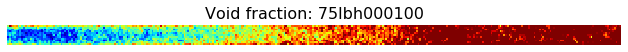

In [4]:
plot_channel_image(img, title='Void fraction: {}'.format(L))


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


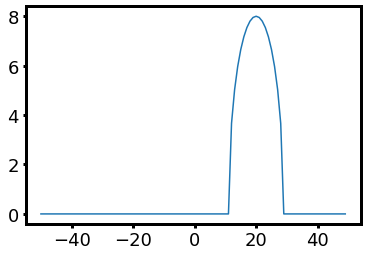

In [5]:

x = np.arange(100)-50
y = multi_cross_sec_ellipse(x, 20, 9, 4, 60, 4, 5)
plt.plot(x,y)
plt.show()


In [8]:
def get_guess(x, y, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed. 
    """
    guess = []
    low_bounds = []
    high_bounds = []
    center_increment = (np.max(x)-np.min(x))/n
    
    for g in range(n):
        guess += [
            center_increment*(g+1), # center x-coordinate
            (np.max(x)-np.min(x))/(2*n), # x-radius
            np.mean(y)/2] # y-radius
        low_bounds += []
        high_bounds += []
    return guess, (low_bounds, high_bounds)
'''
for i in range(1):
    
    profile = resample(np.column_stack((np.arange(img.shape[0]), img[:, i]/250)))
    #profile[:, 1] -= np.min(profile[:, 1])
    
    plt.scatter(profile[:, 0], profile[:, 1], alpha=0.3, s=10, c='k')

    guess, bounds = get_guess(profile[:, 0], profile[:, 1], 4)

    guess = [5, 2, 0.3,
             1.5, 2, 0.3,
             9, 2, 0.3,
             7, 2, 0.3,
             3, 2, 0.3]

    
    popt, _ = curve_fit(multi_cross_sec_ellipse, profile[:, 0], profile[:, 1], p0=guess)
    fit = multi_cross_sec_ellipse(profile[:, 0], *popt)
    
    plt.plot(profile[:, 0], fit, c='k')

    
    for p in range(0, len(popt), 3):
        fit0 = multi_cross_sec_ellipse(profile[:, 0], *popt[p:p+3])
        plt.plot(profile[:, 0], fit0)
        
plt.show()
'''

"\nfor i in range(1):\n    \n    profile = resample(np.column_stack((np.arange(img.shape[0]), img[:, i]/250)))\n    #profile[:, 1] -= np.min(profile[:, 1])\n    \n    plt.scatter(profile[:, 0], profile[:, 1], alpha=0.3, s=10, c='k')\n\n    guess, bounds = get_guess(profile[:, 0], profile[:, 1], 4)\n\n    guess = [5, 2, 0.3,\n             1.5, 2, 0.3,\n             9, 2, 0.3,\n             7, 2, 0.3,\n             3, 2, 0.3]\n\n    \n    popt, _ = curve_fit(multi_cross_sec_ellipse, profile[:, 0], profile[:, 1], p0=guess)\n    fit = multi_cross_sec_ellipse(profile[:, 0], *popt)\n    \n    plt.plot(profile[:, 0], fit, c='k')\n\n    \n    for p in range(0, len(popt), 3):\n        fit0 = multi_cross_sec_ellipse(profile[:, 0], *popt[p:p+3])\n        plt.plot(profile[:, 0], fit0)\n        \nplt.show()\n"

## Add elipses to channel cross section

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in sqrt


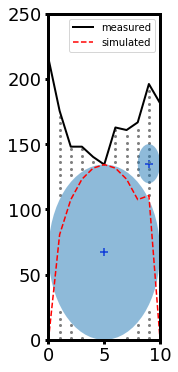

In [57]:
# use this to reample the cross section for higher resolution
#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:,i])))
cs = np.column_stack((np.arange(img.shape[0]), img[:, 60]))

# create dictionary for elliptical bubble dimensions (center, width, height)
# the initial bubble is created as large as possible to fit inside measured cross section
bub = {
    'c': [[np.max(cs[:, 0])/2, np.min(cs[:, 1])/2]],
    'w': [np.max(cs[:, 0])],
    'h': [np.min(cs[:, 1])],
    'verts': []}

# create initial ellipse
ellipse_object = patches.Ellipse(bub['c'][0], bub['w'][0], bub['h'][0], alpha=0.5)
ellipse_vertices = get_ellipse_vertices(ellipse_object)
bub['verts'].append(ellipse_vertices)
# create simulated cross section to hold ellipse cross sections and plot it
sim_cs = ellipse_integral(cs[:,0], bub['c'][0][0], bub['w'][0], bub['h'][0])


# plot initial ellipse
fig, ax = plt.subplots()
ax.add_patch(ellipse_object)
ax.scatter(*bub['c'][0], marker='+', s=80, c='b')
# add void fraction cross section to plot
ax.plot(cs[:,0], cs[:,1], lw=2, c='k', label='measured')


# calculate residual between measured and simulated cross sections
residual = np.column_stack((cs[:, 0], cs[:, 1]-sim_cs))



# create new bubbles
for b in range(1, 2):
    
    # calculate residual between measured and simulated cross sections
    residual = np.column_stack((cs[:, 0], cs[:, 1]-sim_cs))

    new_c, new_w, new_h = [9, 135], 2, 30
    bub['c'].append(new_c)
    bub['w'].append(new_w)
    bub['h'].append(new_h)
    
    
    # add ellipse cross section to total simulated cross section 
    sim_cs += ellipse_integral(cs[:,0], bub['c'][b][0], bub['w'][b], bub['h'][b])
    
    # plot new ellipse
    ellipse_object = patches.Ellipse(bub['c'][b], bub['w'][b], bub['h'][b], alpha=0.5)
    ellipse_vetices = get_ellipse_vertices(ellipse_object)
    bub['verts'].append(ellipse_vertices)
    ax.add_patch(ellipse_object)
    ax.scatter(*bub['c'][b], marker='+', s=80, c='b')


    

    # generate new bubble
    potential_centers = []
    for xi in range(1, len(cs)-1):
         for yi in range(1, int(np.floor(cs[xi, 1])), 5):
            point = Point(xi, yi)
                
            polygon = Polygon(v)

            for v in bub['verts']:
            if not polygon.contains(point):
                potential_centers.append([xi, yi])


    [ax.scatter(*pot, s=4, c='gray') for pot in potential_centers]

    
    

    
# plot simulated void fraction cross section
ax.plot(cs[:, 0], sim_cs, c='r', linestyle='--', label='simulated')
plt.xlim([cs[0, 0], cs[-1, 0]])
plt.ylim([0, data['d_um']])
fig.set_size_inches(2, 6)
plt.legend()
plt.show()

In [ ]:
ellipse = patches.Ellipse(bub['c'][0], bub['w'][0], bub['h'][0], alpha=0.2)

vert = get_ellipse_vertices(ellipse)
plt.plot(vert[:, 0], vert[:, 1])
plt.show()


#print(ellipse)
#print(ellipse.get_path())
#print(ellipse.get_patch_transform())

In [29]:
[print(residual[i, 1]+1) for i in range(len(residual))]

216.68627450980392
95.90196078431372
41.58823529411764
25.938652900205867
9.596041270080235
1.0
32.145060877923385
38.683750939421586
60.21568627450979
116.49019607843137
182.37254901960785


[None, None, None, None, None, None, None, None, None, None, None]

### Plot circles in channel cross section

In [ ]:
'''
starttime = time()

# loop over each image
for L in list(model_info['channels']):

    # get target image to model
    measured_image = model_info['channels'][L]['img_voidfrac']

    # get list of channel index coordinates and potential bubbles
    channel_coords = get_channel(measured_image.shape)
    bub_dict = get_bubbles(model_info, measured_image)

    # simulate empty channel to populate with simulated bubbles
    sim = {
        'label': L,
        'flowrate': model_info['channels'][L]['flowrate'],
        'temp': model_info['channels'][L]['temp'],
        'img_model': np.zeros_like(measured_image),
        'img_voidfrac': measured_image,
        'cent': [],
        'rad': []}
    
    # pixels to add to each bubble as a fluid buffer
    buffer_pixels = model_info['buffer_um']/model_info['um_per_pixel']
    
    # loop over each bubble to try and fit into the channel
    for i in range(len(bub_dict['rad'])):

        # get z-profile of new bubble
        bub_profile = 2*np.sqrt(bub_dict['rad_squared'][i]
                                - np.square(channel_coords[:, 0]-bub_dict['x'][i])
                                - np.square(channel_coords[:, 1]-bub_dict['y'][i])) + buffer_pixels


        # convert nan to 0 and reshape to channel size
        bub_profile = np.where(np.isnan(bub_profile),
                               0, bub_profile).reshape(sim['img_model'].shape)


        # add new bubble to channel if it will fit
        if np.all(sim['img_model'] + bub_profile <= 1.02*sim['img_voidfrac']):
            sim['img_model'] += bub_profile
            sim['rad'].append(bub_dict['rad'][i])
            sim['cent'].append([bub_dict['x'][i], bub_dict['y'][i]])


    # get total avg error between image and model
    tot_err = np.mean(np.abs((sim['img_model']-sim['img_voidfrac'])/sim['img_voidfrac']))*100
    sim['percent_error'] = round(tot_err, 2)
    
    # save model to file on local machine
    save_model_path = os.path.join(os.getcwd(), 'models', L + '__model.npy')
    np.save(save_model_path, sim)
    
    # show original channel image
    plot_channel_image(sim['img_voidfrac'], title='Measured image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # show simulated channel image
    plot_channel_image(sim['img_model'], title='Simulated image '+L,
                       vmin=0, vmax=model_info['d_um'])
    plt.show()

    # print statistics of model
    print('bubbles in channel: {}'.format(len(sim['rad'])))
    print('total runtime (min): {}'.format(round((time() - starttime)/60,1)))
    print('simulation error (%): {}'.format(round(tot_err, 2)))
    print('--------------------------------------------------------------\n')
'''

## Model the void fraction in each channel image

Now we use Monte Carlo methods to construct possible bubble configurations
in the channel which will approximate the experimentally-measured
void fraction in each image. This is carried out by beginning at the first
column of pixlels and adding disks (cross-sectional slices) of bubbles.

Then we progress to the next pixel column and add new cross sections
based on which disks were present in the preceeding pixel column.

First we import the trimmed channel images from the dictionary file.
Then we loop over each image, construct an empty simulated channel, and
incrementally add disks to it.

The simulated channel models are saved to file in the *\models* directory.
Each model is saved as a Python dictionary and corresponds
to a particular channel image. The model includes:
* **label**: (filename) of the original channel image
* **img_model**: simulated channel image
* **img_voidfrac**: measured void fraction image
* **cent**: the centers of the simulated bubbles, in ordered pairs (x, y)
* **rad**: the radii of the simulated bubbles
* **percent_error**: total percent error between the measured channel image and the simulated channel image